# Mealbox service review sentiment analysis
## Part 1: Scraping Reviews

In [1]:
#importing the necessary function from created module to scrape data
import nbimporter
from review_scraper import *

In [ ]:
#Scraping Google reviews
marley_spoon_google_scrape()

In [ ]:
#Scraping Consumer Affairs reviews
blue_apron_consumeraffairs_scrape()
hello_fresh_consumeraffairs_scrape()

In [ ]:
#Scraping Trustpilot reviews
blue_apron_trustpilot_scrape()
hello_fresh_trustpilot_scrape()
marley_spoon_trustpilot_scrape()

## Part 2: Cleaning Review Data / Labeling
The reviews that have been scraped using the above functions have been merged and cleaned using Microsoft Excel. The result was a file containing over 15k reviews of Marley Spoon, Hello Fresh and Blue Apron. Blue Apron did not have enough reviews within the time range of this research (Q1, Q2, Q3 2020). Therefore, we limited this research to just include Marley Spoon and Hello Fresh. <br>

Since sentiment analysis on mealbox services has not been performed yet (at least not published), we were unable to train our model on an existing and labeled data set. To train the review sentiment model, 600 observations have been manually labeled to positive (1) or negative (0). 

The final result was an Excel workbook containing three sheets:
<ul>
  <li>All reviews (unlabeled)</li>
  <li>All labeled reviews (training set)</li>
  <li>All unlabeled reviews (All reviews - All labeled reviews)</li>
</ul>

## Part 3: Train models

The following models have been trained and reviewed for their accuracy:
<ul>
  <li>Random Forest Classifier</li>
  <li>Decision Tree Classifier</li>
  <li>Logistic Regression Classifier</li>
</ul>

In [2]:
#Importing the three sheets as specified under part 2.
import pandas as pd
all_reviews_unlabeled = pd.read_excel('Unlabeled (A), Labeled (B) and A - B.xlsx', sheet_name = 'Unlabeled total (A)')
all_reviews_labeled = pd.read_excel('Unlabeled (A), Labeled (B) and A - B.xlsx', sheet_name = 'Labeled total (B)')
all_labeled_reviews = pd.read_excel('Unlabeled (A), Labeled (B) and A - B.xlsx', sheet_name = 'A-B')

### Training a Random Forest Classifier

In [3]:
#Importing the necessary libraries
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from nltk.corpus import stopwords
from collections import Counter

#In order to interact with the data in a easier way, will transfer the data to a dataframe
df_labelled = all_reviews_labeled[['Label', 'Review']]

#Just in case I will check for null values, shouldn't be any removed them in excel
print('Check for null values: ',df_labelled[df_labelled['Label'].notnull()])

#Should shuffle the dataset for later since it is a good practice
df_lablled_2 = df_labelled.copy()
df_labelled_2 = df_labelled.sample(frac=1)

#Vectorization: will use bag of words model
vectorizer = TfidfVectorizer()
bow = vectorizer.fit_transform(df_labelled_2['Review'])
labels = df_labelled_2['Label']
#to see how many unique words (features) we have
print('Total number of unique features:', len(vectorizer.get_feature_names()))

#rule of thumb, should try to have at least ten time as many samples as features
#so, will try to reduce the number of features by removing words which appear infrequently (less than 0.5%)
vectorizer_2 = TfidfVectorizer(min_df=15)
bow_2 = vectorizer_2.fit_transform(df_labelled_2['Review'])
labels_2 = df_labelled_2['Label']
print('Total number of unique features:', len(vectorizer_2.get_feature_names()))
#the result is 254, which is more acceptable

#Data partition: train and test sets 2/3 to train, 1/3 to test
X_train, X_test, y_train, y_test = train_test_split(bow_2, labels_2, test_size=0.33)

#Classifier: Random Forest(collections of decision trees)
classifier = rfc()
classifier.fit(X_train,y_train)
print('Classifier Model Score:',classifier.score(X_test,y_test))

#Hyperparameter Optimization:maximizing performance
classifier_2 = rfc()
hyperparameters = {'n_estimators':stats.randint(10,300),'criterion':['gini','entropy'],
    'min_samples_split':stats.randint(2,9),'bootstrap':[True,False]}
random_search = RandomizedSearchCV(classifier_2, hyperparameters, n_iter=65, n_jobs=4)
random_search.fit(bow_2, labels_2)
optimized_classifier = random_search.best_estimator_
optimized_classifier.fit(X_train,y_train)
print('Classifier Optimized Model Score:', optimized_classifier.score(X_test,y_test))

Check for null values:       Label                                             Review
0        1  This has been a Godsend. Just had a knee repla...
1        1  Lot of the entrees are nutritional.Packaging i...
2        1  I started using HelloFresh because I got reall...
3        1  Love HelloFresh! Delivered to your door with e...
4        1  We have been very pleased with everything that...
..     ...                                                ...
573      0  The quality of ingredient is hit or miss. Not ...
574      0  I give them a four. The convenience of the del...
575      0  These guys pissed me off every chance they got...
576      1  Makes deciding what to eat and cooking dinner ...
577      1     Love this. Family time cookin and amazing food

[578 rows x 2 columns]
Total number of unique features: 2492
Total number of unique features: 256
Classifier Model Score: 0.8115183246073299
Classifier Optimized Model Score: 0.8115183246073299


### Training a Decision Tree Classifier

In [4]:
#In order to interact with the data in a easier way, will transfer the data to a dataframe
df_labelled = all_reviews_labeled[['Label', 'Review']]

#check for nulls within the dataframe
print('Check for null values: ',df_labelled[df_labelled['Label'].notnull()])

#randomize the date under the sample size
#so we don't have under numerical order within the data frame
df_lablled_2 = df_labelled.copy()
df_labelled_2 = df_labelled.sample(frac=1)
df_labelled_2

#preprocessing the inputs
#assign the data input for the label encoder
from sklearn import preprocessing
datainput = df_labelled_2

#use the label enconder function to convert the sting reviews into floats for our model is readable
# since the labels are already encoded, the function will not make a difference except for
#the Reviews column
from sklearn.preprocessing import LabelEncoder
le_Number=LabelEncoder()
le_Review= LabelEncoder()
datainput['Review_n']=le_Number.fit_transform(datainput['Review'])
datainput.drop(["Review"],axis=1)

#assign X and y for the traning data set
#datainput is still the same randomized dataframe yet encoded so the Reviews can fit the tree model
X=datainput['Review_n'].values
y=datainput[["Label"]].values

#We use the KFold to perfrom a Cross Validation for the train and test data set
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)
kf.get_n_splits(y)

#find the shapes and train the datasets
# new update from the sklearn.model_selection is the same module for the sklearn.cross_validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# constructing the model and shape the arrays
#use the Descion Tree module from the sklearn library
from sklearn import tree
model = tree.DecisionTreeClassifier()
X_train=X_train.reshape(-1,1)
y_train=y_train.reshape(-1,1) 
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)
model.fit(X_train, y_train)

#test for accuracy for the model
#max depth will determing the dept of the tree and the random_state is the random genrations assigned
from sklearn import metrics
clf = tree.DecisionTreeClassifier(max_depth = 2, 
                             random_state = 0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("\nDecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, y_pred))

Check for null values:       Label                                             Review
0        1  This has been a Godsend. Just had a knee repla...
1        1  Lot of the entrees are nutritional.Packaging i...
2        1  I started using HelloFresh because I got reall...
3        1  Love HelloFresh! Delivered to your door with e...
4        1  We have been very pleased with everything that...
..     ...                                                ...
573      0  The quality of ingredient is hit or miss. Not ...
574      0  I give them a four. The convenience of the del...
575      0  These guys pissed me off every chance they got...
576      1  Makes deciding what to eat and cooking dinner ...
577      1     Love this. Family time cookin and amazing food

[578 rows x 2 columns]
(387,)
(191,)
(387, 1)
(191, 1)

DecisionTrees's Accuracy:  0.7696335078534031


### Training a Logistic Regression Classifier

In [5]:
#Import the necessary libraries
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

#Read the data in a pandas data frame
df_labelled = all_reviews_labeled[['Label', 'Review']]

#Splitting the review and labeled values
review_text = df_labelled['Review'].values
sentiment_labels = df_labelled['Label'].values

#Splitting the data in train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(review_text, sentiment_labels, test_size=0.2, random_state=1)

#Tokenize and build a vocubalary of known words
vectorizer = CountVectorizer()
vectorizer.fit(reviews_train)

#Setting the X train and X test with the vectorized review data
X_train = vectorizer.transform(reviews_train)
X_test = vectorizer.transform(reviews_test)

#Set placeholder variable for number of folds
kfolds = 5

#Set the min and max alpha for the cross-validation to find it's optimal level between
min_alpha = 0.01
max_alpha = 100

#Generate the inverse of the min and max alpha since this is a requirement for LogisticRegressionCV
max_C = 1/min_alpha
min_C = 1/max_alpha

#Set the number of candidates
n_candidates = 5000

#Import numpy to be able to create the list below
import numpy as np

#Create list to store C points in
C_list = list(np.linspace(min_C, max_C, num=n_candidates))

#Run the logistic regression cross-validation with a scoring metric of roc_auc
clf_optimal = LogisticRegressionCV(Cs=C_list, cv=kfolds, max_iter=400, random_state=1, n_jobs=-1).fit(X_train, y_train)

#Retrieve the accuracy
accuracy = clf_optimal.score(X_test, y_test)
print('Optimal Logistic Regression Classifier Accuracy:',accuracy)

Optimal Logistic Regression Classifier Accuracy: 0.9051724137931034


The Logistic Regression Classifier proves to be the most accurate model. 

## Part 4: Predicting the sentiment on the total data set

In [6]:
#Tokenize and build a vocubalary of known words
new_reviews = all_labeled_reviews['Review'].values
X_newData = vectorizer.transform(new_reviews)

#Predict the sentiment labels
new_predictions = clf_optimal.predict(X_newData)

In [7]:
#Copying data frame to avoid changing the original data
labeled_reviews = all_labeled_reviews.copy()

#Keeping only the relevant data
labeled_reviews = labeled_reviews[['Review', 'Company', 'Date Posted']]

#Adding a new column containing the new predictions
labeled_reviews['Label'] = new_predictions

#Appending the data that was already labeled
labeled_reviews = labeled_reviews.append(all_reviews_labeled[['Review', 'Company', 'Date Posted', 'Label']])

#Filtering out data that does not fall within Q1, Q2 or Q3
final = labeled_reviews.copy()

labeled_reviews_1 = labeled_reviews[(labeled_reviews['Date Posted'] >= '2020-01-01') & (labeled_reviews['Date Posted'] <= '2020-09-30')]

## Part 5: Analysis
### Keyword Analysis

In [8]:
#Create a list with the columns of the dataframe we are interested to keep for the analysis
col_keep = ['Review', 'Label']
data_final = labeled_reviews_1[col_keep]

#Separated reviews into positive and negative based on their label and droped the label column since we don't need them anymore
positive_reviews = data_final.loc[data_final['Label']==1].drop(columns='Label')
negative_reviews = data_final.loc[data_final['Label']==0].drop(columns='Label')

#User defined function to measure term frequency 
def getmostcommonwords(reviews, n_most_common, stopwords=None):
    #Flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [i for rev in reviews for i in rev.lower().split()]
    #remove punctuation from the reviews
    flattened_reviews = [''.join(char for char in rev if char not in string.punctuation) for rev in flattened_reviews]
    #remove stopwords if applicable
    if stopwords:
        flattened_reviews = [word for word in flattened_reviews if word not in stopwords]        
    #remove any empty string that were created by this process
    flattened_reviews = [rev for rev in flattened_reviews if rev]
    return Counter(flattened_reviews).most_common(n_most_common)

#Remove certain stopwords from the list of stopwords
stop_words = set(stopwords.words('english'))
remove_words = set(('no','nor','not',"don't",'don','aren',"aren't"\
                    "doesn't",'doesn', "didn't", 'didn','isn',"isn't"\
                    "wasn't",'wasn'))
new_stop_words = stop_words.difference(remove_words)   

#Peliminary analysis with the objective of getting the FT
#Most frequent words in positive dataframe with stopwords
print('Most Common Words from positive reviews with stopwords NOT MERGING NOT: ',getmostcommonwords(positive_reviews['Review'], 50))
#Most frequent words in positive dataframe without stopwords   
print('Most Common Words from positive reviews without stopwords NOT MERGING NOT: ',getmostcommonwords(positive_reviews['Review'], 50,new_stop_words))
#Most frequent words in negative dataframe with stopwords
print('Most Common Words from negative reviews with stopwords NOT MERGING NOT: ',getmostcommonwords(negative_reviews['Review'], 50))
#Most frequent words in negative dataframe without stopwords   
print('Most Common Words from negative reviews without stopwords NOT MERGING NOT: ',getmostcommonwords(negative_reviews['Review'], 50,new_stop_words))

#Since we noticed that a lot of the negative characteristics of the kit meal service
#were denotated using words like 'not', 'no', 'didn't, etc we used a 
#User defined function to concatenate certain words to the next,
#this way we are making sure we are not missing important negations
def negate(text):

    negation = False
    include = True
    result = []
    words = text.split()

    for word in words:
        if any(neg in word for neg in ["not", "n't", "no", "didn't","can't",'didnt'\
                                       'nor',"don't",'don','aren',"aren't"\
                                       "doesn't",'doesn','isn',"isn't"\
                                       "wasn't",'wasn']):
            include = False
            
        stripped = word.strip('-').lower()
        negated = "not" + stripped if negation else stripped
        if include:
            result.append(negated)
        negation = False
        include  = True

        if any(neg in word for neg in ["not", "n't", "no", "didn't","can't",'didnt'\
                                       'nor',"don't",'don','aren',"aren't"\
                                       "doesn't",'doesn','isn',"isn't"\
                                       "wasn't",'wasn']):
            negation = not negation
            
    
    result_2 = ' '.join(result)
    return result_2

#changed the dataframe to a list in order to use the user defined function
pos_rev_2 = positive_reviews['Review'].values.tolist()
neg_rev_2 = negative_reviews['Review'].values.tolist()

#Used map to create new positive and negative reviews, that include the not before
#the words identified in the user defined function
pos_rev_3 = list(map(negate,pos_rev_2))
neg_rev_3 = list(map(negate,neg_rev_2))

#Created two data frames, one with positive and one with negative reviews which includes the not nefore the words
#identified in the user defined function
df_labelled_positive = pd.DataFrame(data=pos_rev_3, columns=['Review'])
df_labelled_negative = pd.DataFrame(data=neg_rev_3,columns=['Review'])

#Most frequent words in positive dataframe with stopwords
print('Most Common Words from positive reviews with stopwords: ',getmostcommonwords(df_labelled_positive['Review'], 75))
#Most frequent words in positive dataframe without stopwords   
print('Most Common Words from positive reviews without stopwords: ',getmostcommonwords(df_labelled_positive['Review'], 75,new_stop_words))
#Most frequent words in negative dataframe with stopwords
print('Most Common Words from negative reviews with stopwords: ',getmostcommonwords(df_labelled_negative['Review'], 75))
#Most frequent words in negative dataframe without stopwords   
print('Most Common Words from negative reviews without stopwords: ',getmostcommonwords(df_labelled_negative['Review'], 75,new_stop_words))

#Next step was to calculate de TF-IDF for the positive reviews removing the stopwords and using negate function
tfidfVectorizer_pos = TfidfVectorizer(stop_words = new_stop_words,use_idf=True)
#Here I get the tfidf of each words
tfidf = tfidfVectorizer_pos.fit_transform(pos_rev_3)
#Sum the rows of the matrix to get the tfidf of each word across all the reviews
sum_of_tfidf = tfidf.sum(axis=0)
#Saved matrix to data frame and got the words associated witht the tfidf
#and order them in according to the tfidf value
df_tfidf_positive = pd.DataFrame(data = sum_of_tfidf.T,index=tfidfVectorizer_pos.get_feature_names(),columns=['TF-IDF']).sort_values('TF-IDF', ascending=False)
#Saved the data frame to a csv file
df_tfidf_positive.to_csv('TI-IDF-Positive.csv') 


#Calculate de TF-IDF for the negative reviews removing the stopwords and using negate function
tfidfVectorizer_neg = TfidfVectorizer(stop_words = new_stop_words,use_idf=True)
#Here I get the tfidf of each words
tfidf_neg = tfidfVectorizer_neg.fit_transform(neg_rev_3)
#Sum the rows of the matrix to get the tfidf of each word across all the reviews
sum_of_tfidf_neg = tfidf_neg.sum(axis=0)
#Saved matrix to data frame and got the words associated witht the tfidf
#and order them in according to the tfidf value
df_tfidf_negative = pd.DataFrame(data=sum_of_tfidf_neg.T,index=tfidfVectorizer_neg.get_feature_names(),columns=['TF-IDF']).sort_values('TF-IDF', ascending=False)

Most Common Words from positive reviews with stopwords NOT MERGING NOT:  [('the', 22324), ('and', 18522), ('to', 15431), ('i', 14016), ('a', 9638), ('is', 7686), ('of', 7479), ('have', 7445), ('are', 6814), ('meals', 6680), ('fresh', 6225), ('we', 5977), ('for', 5950), ('it', 5068), ('my', 4979), ('food', 4212), ('with', 4211), ('that', 4168), ('been', 3923), ('easy', 3918), ('hello', 3826), ('love', 3597), ('great', 3597), ('recipes', 3575), ('in', 3402), ('so', 3310), ('meal', 3028), ('but', 2982), ('delicious', 2844), ('has', 2809), ('very', 2583), ('was', 2534), ('not', 2495), ('service', 2478), ('good', 2444), ('all', 2427), ('this', 2379), ('they', 2313), ('you', 2294), ('time', 2168), ('on', 2146), ('ingredients', 2139), ('had', 1987), ('our', 1954), ('hellofresh', 1906), ('as', 1833), ('week', 1793), ('be', 1702), ('would', 1686), ('always', 1655)]
Most Common Words from positive reviews without stopwords NOT MERGING NOT:  [('meals', 6680), ('fresh', 6225), ('food', 4212), ('ea

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'doesn', 'isn', 'wasn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'doesn', 'isn', 'wasn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


### Financial Comparison (Hello Fresh, Blue Apron, Marley Spoon)

In [9]:
###Blue Apron
apron_rev = pd.read_csv("Apron Rev.csv")

#Rename column "Orders (in thousands)" to "orders" column 
apron_rev = apron_rev.rename(columns ={'Orders (in thousands)':'orders'}) 

#Rename column "Customers (in thousands)" to "customer" column 
apron_rev = apron_rev.rename(columns ={'Customers (in thousands)':'customer'}) 

#Rename column "Net Revenue (in millions)" to "rev" column 
apron_rev = apron_rev.rename(columns ={'Net Revenue (in millions)':'rev'})

###Marley Spoon
marley_rev = pd.read_csv("Marley Rev.csv")

#Rename column "Number of orders (in thousands)" to "orders"
marley_rev = marley_rev.rename(columns ={'Number of orders (in thousands)':'orders'}) 

#Rename column "Active customer (in thousands)" to "customer"
marley_rev = marley_rev.rename(columns ={'Active customer (in thousands)':'customer'}) 

#Rename column "Net Revenue (in millions)" to "rev" column 
marley_rev = marley_rev.rename(columns ={'Net Revenue (in millions)':'rev'}) 

###Hello Fresh
hello_rev = pd.read_csv("HF Rev.csv")

# Rename column "Number of orders(in millions)" to "orders"
hello_rev = hello_rev.rename(columns ={'Number of orders(in millions)':'orders'}) 

#Rename column 'Active customers(in millions)' to 'customer'
hello_rev = hello_rev.rename(columns = {'Active customers(in millions)': 'customer'})

#Rename column "Revenue (in MUSD)" to "rev" column 
hello_rev = hello_rev.rename(columns ={'Revenue (in MUSD)':'rev'}) 

#convert value in column order from in millions to in thousands for comparison purpose
hello_rev['orders'] = (hello_rev['orders'].astype(float)*1000)
hello_rev

#convert value in column customer from in millions to in thousands for comparison purpose
hello_rev['customer'] = (hello_rev['customer'].astype(float)*1000)
hello_rev

,Date,customer,orders,Order per customer,Meals(in millions),Average order value(USD),Average order value constant currency(USD),rev,Contribution margin (in MUSD),Contribution margin( in % of Revenue),Stock Price (USD) (3/31/2020)
0,3/31/2020,4180.0,8950.0,3.4,61.3,57.81,56.15,518.39,156.09,0.300,36.414
1,6/30/2020,1980.0,8870.0,4.5,63.9,70.40,69.00,625.82,152.08,0.242,56.410
2,9/30/2020,2490.0,9970.0,4.0,72.7,52.70,55.50,526.30,127.90,0.242,45.920


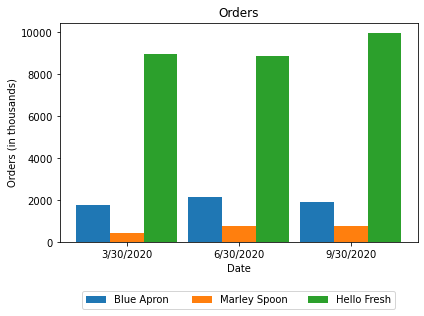

In [11]:
###Creating a bar chart for comparison

import matplotlib.pyplot as plt

date = apron_rev['Date']
x = np.arange(len(apron_rev['Date']))
w = 0.3

plt.bar(x-w, apron_rev['orders'].values, width = w, label = "Blue Apron ")
plt.bar(x, marley_rev['orders'].values, width = w, label = "Marley Spoon")
plt.bar(x+w, hello_rev['orders'].values, width = w, label = "Hello Fresh")

plt.title('Orders', loc='center') # add title
plt.xticks(x, date)   #define x to be date
plt.xlabel("Date")   #add label for x
plt.ylabel("Orders (in thousands)")    #add label for y 
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=5)   # anotation box position

plt.show()

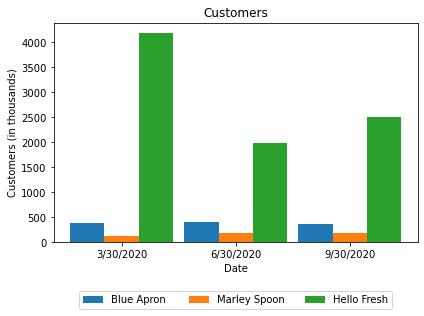

In [12]:
date = apron_rev['Date']
x = np.arange(len(apron_rev['Date']))
w = 0.3
plt.bar(x-w, apron_rev['customer'].values, width = w, label = "Blue Apron ")
plt.bar(x, marley_rev['customer'].values, width = w, label = "Marley Spoon")
plt.bar(x+w, hello_rev['customer'].values, width = w, label = "Hello Fresh")

plt.title('Customers', loc='center') # add title
plt.xticks(x, date)  #define x to be date
plt.xlabel("Date")   #add label for x
plt.ylabel("Customers (in thousands)")   #add label for y 
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=5)   # anotation box position

plt.show()

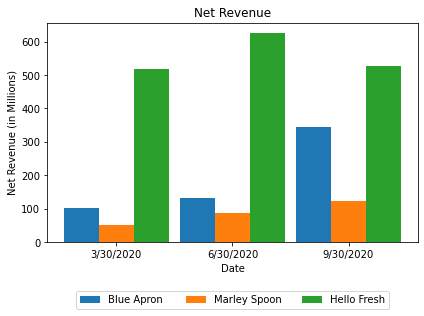

In [13]:
date = apron_rev['Date']
x = np.arange(len(apron_rev['Date']))
w = 0.3

plt.bar(x-w, apron_rev['rev'].values, width = w, label = "Blue Apron ")
plt.bar(x, marley_rev['rev'].values, width = w, label = "Marley Spoon")
plt.bar(x+w, hello_rev['rev'].values, width = w, label = "Hello Fresh")

plt.title('Net Revenue', loc='center') # add title
plt.xticks(x, date)    #define x to be date
plt.xlabel("Date")       #add label for x
plt.ylabel("Net Revenue (in Millions)")      #add label for y
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, ncol=5)     # anotation box position

plt.show()

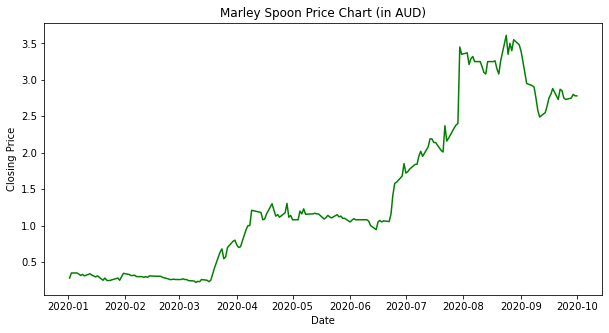

In [14]:
###Stock prices

##Marley Spoon
#read the HFG.DE.csv file
marley = pd.read_csv("MMM.AX.csv")

#Rename Pandas columns to lower case
marley = marley.rename(str.lower, axis = 'columns')

#Rename Pandas columns to remove white space
marley.columns = marley.columns.str.replace(' ', "")
marley.head()

#Convert the format on Date column to YYYY-MM
marley['date'] = pd.to_datetime(marley['date'].astype(str), format = '%Y-%m')

#Create Plot line chart for stock price
fig, ax = plt.subplots(figsize = (10,5))

#add x-axis and y-axis
ax.plot(marley['date'], marley['close'], color = 'green')

#Set title and labels for axes
ax.set(xlabel = "Date", 
      ylabel = "Closing Price", 
      title = "Marley Spoon Price Chart (in AUD)")

plt.show()

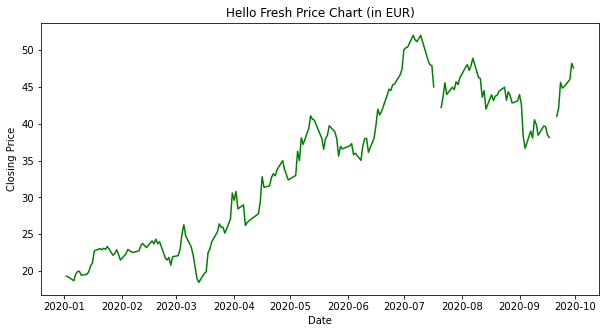

In [15]:
##Hello Fresh
#read the HFG.DE.csv file
hellofresh = pd.read_csv("HFG.DE.csv")

#Rename Pandas columns to lower case
hellofresh = hellofresh.rename(str.lower, axis = 'columns')

#Rename Pandas columns to remove white space
hellofresh.columns = hellofresh.columns.str.replace(' ', "")
hellofresh.head()

#Convert the format on Date column to YYYY-MM
hellofresh['date'] = pd.to_datetime(hellofresh['date'].astype(str), format = '%Y-%m')

#Create Plot line chart for stock price
fig, ax = plt.subplots(figsize = (10,5))

#add x-axis and y-axis
ax.plot(hellofresh['date'], hellofresh['close'], color = 'green')

#Set title and labels for axes
ax.set(xlabel = "Date", 
      ylabel = "Closing Price", 
      title = "Hello Fresh Price Chart (in EUR)")

plt.show()

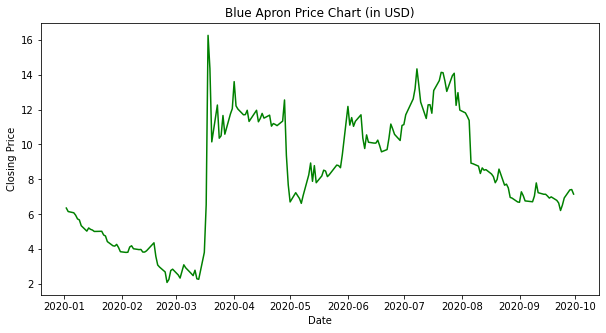

In [16]:
##Blue Apron
#read the APRN.csv file
apron = pd.read_csv("APRN.csv")

#Rename Pandas columns to lower case
apron = apron.rename(str.lower, axis = 'columns')

#Rename Pandas columns to remove white space
apron.columns = apron.columns.str.replace(' ', "")
apron.head()

#Convert the format on Date column to YYYY-MM
apron['date'] = pd.to_datetime(apron['date'].astype(str), format = '%Y-%m')

#Create Plot line chart for stock price
fig, ax = plt.subplots(figsize = (10,5))

#add x-axis and y-axis
ax.plot(apron['date'], apron['close'], color = 'green')

#Set title and labels for axes
ax.set(xlabel = "Date", 
      ylabel = "Closing Price", 
      title = "Blue Apron Price Chart (in USD)")

plt.show()

### Financials vs. Sentiment Relationship Analysis

Label        0     1
quarters            
1         0.17  0.83
2         0.32  0.68
3         0.20  0.80
Label        0     1
quarters            
1         0.10  0.90
2         0.11  0.89
3         0.20  0.80


Text(0.5, 1.0, 'Review and Revenue Changes in 9 months - Marley Spoon')

<Figure size 432x288 with 0 Axes>

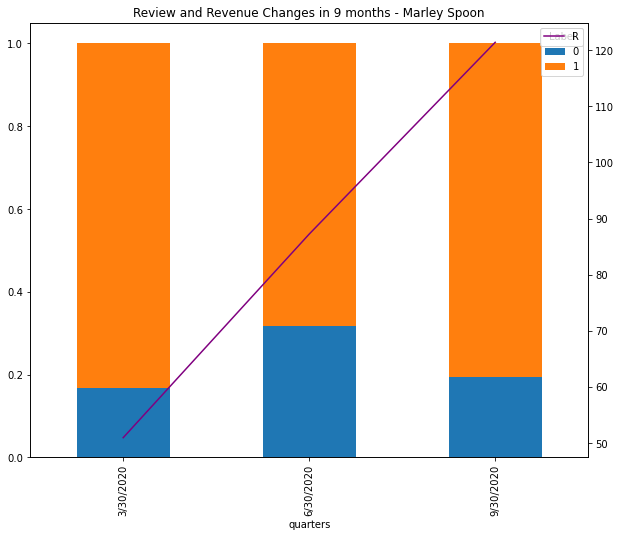

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from datetime import datetime
pd.set_option('display.precision', 2)
import re

data = labeled_reviews_1.copy()

data['week'] = data['Date Posted'].dt.week
data['quarters'] = data['Date Posted'].dt.quarter
data['month'] = data['Date Posted'].dt.month

marley_df = data[data['Company'] == 'Marley Spoon']
hello_df = data[data['Company'] == 'Hello Fresh']

#Creating a percentage of total Crosstab for Marley Spoon
marley_spoon_crossTab_week = pd.crosstab(marley_df['week'], marley_df["Label"]).apply(lambda r: r/r.sum(), axis=1)
 
#Creating a percentage of total Crosstab for Hello Fresh
hello_fresh_crossTab_week = pd.crosstab(hello_df['week'], hello_df["Label"]).apply(lambda r: r/r.sum(), axis=1)

### Weekly and monthly for Marley Spoon

#Creating a percentage of total Crosstab for the plot below
marley_spoon_crossTab_quarterly = pd.crosstab(marley_df['quarters'], marley_df["Label"]).apply(lambda r: r/r.sum(), axis=1)
print(marley_spoon_crossTab_quarterly)

marley = pd.read_csv("Marley Rev.csv")
marley

#Rename column "Number of orders (in thousands)" to "orders"
marley = marley.rename(columns ={'Number of orders (in thousands)':'orders'}) 

#Rename column "Active customer (in thousands)" to "customer"
marley = marley.rename(columns ={'Active customer (in thousands)':'customer'}) 

#Rename column "Net Revenue (in millions)" to "rev" column 
marley = marley.rename(columns ={'Net Revenue (in millions)':'rev'}) 

### Weekly and monthly for Hello Fresh
#Creating a percentage of total Crosstab for the plot below
hello_crossTab_quarterly = pd.crosstab(hello_df['quarters'], hello_df["Label"]).apply(lambda r: r/r.sum(), axis=1)

print(hello_crossTab_quarterly)

hello_rev = pd.read_csv("HF Rev.csv")
hello_rev

# Rename column "Number of orders(in millions)" to "orders"
hello_rev = hello_rev.rename(columns ={'Number of orders(in millions)':'orders'}) 

#Rename column 'Active customers(in millions)' to 'customer'
hello_rev = hello_rev.rename(columns = {'Active customers(in millions)': 'customer'})

#Rename column "Revenue (in MUSD)" to "rev" column 
hello_rev = hello_rev.rename(columns ={'Revenue (in MUSD)':'rev'}) 

#convert value in column order from in millions to in thousands for comparison purpose
hello_rev['orders'] = (hello_rev['orders'].astype(float)*1000)
hello_rev

#convert value in column customer from in millions to in thousands for comparison purpose
hello_rev['customer'] = (hello_rev['customer'].astype(float)*1000)
hello_rev

###Create comparison chart for Hello Fresh and Marley Spoon
fig = plt.figure()
ax3 = marley_spoon_crossTab_quarterly.plot(kind = "bar", figsize = (10,8), stacked = True)
ax4 = ax3.twinx()
ax4.plot(marley['Date'], marley['rev'], color = 'purple', label = "Revenue")
ax4.legend('Revenue')
ax3.set_title('Review and Revenue Changes in 9 months - Marley Spoon')

Text(0.5, 1.0, 'Review and Revenue Changes in 9 months - Hello Fresh')

<Figure size 432x288 with 0 Axes>

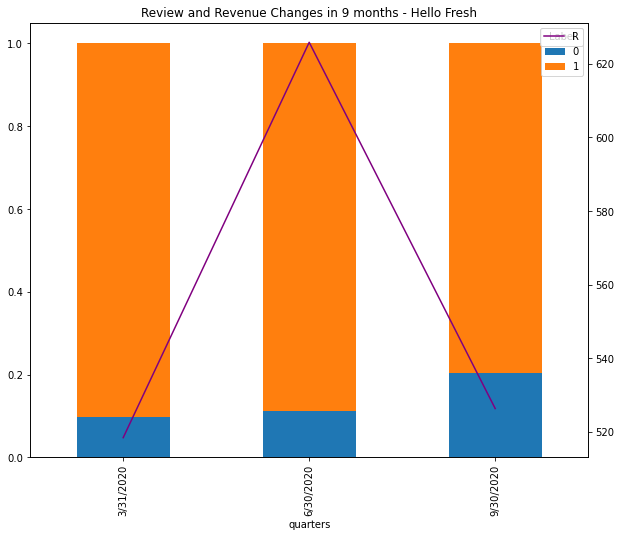

In [18]:
#Combine Revenue chart with label chart:
fig = plt.figure()
ax3 = hello_crossTab_quarterly.plot(kind = "bar", figsize = (10,8), stacked = True)
ax4 = ax3.twinx()
ax4.plot(hello_rev['Date'], hello_rev['rev'], color = 'purple', label = "Revenue")
ax4.legend('Revenue')
ax3.set_title('Review and Revenue Changes in 9 months - Hello Fresh')

Text(0.5, 1.0, 'Review and Orders Changes in 9 months - Hello Fresh')

<Figure size 432x288 with 0 Axes>

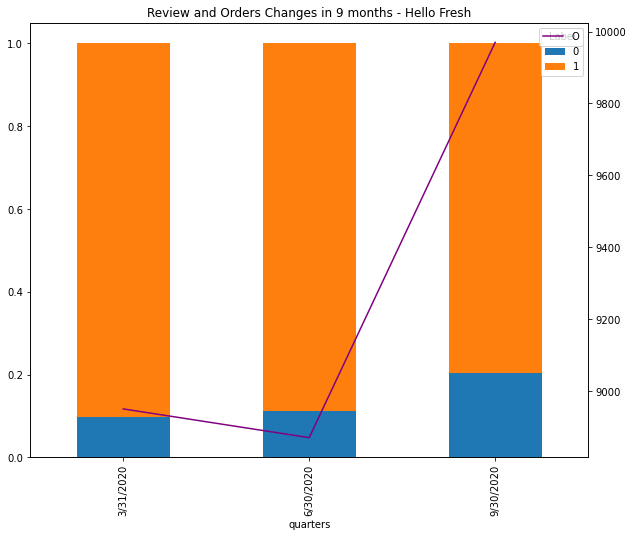

In [19]:
fig = plt.figure()
ax3 = hello_crossTab_quarterly.plot(kind = "bar", figsize = (10,8), stacked = True)
ax4 = ax3.twinx()
ax4.plot(hello_rev['Date'], hello_rev['orders'], color = 'purple', label = "Orders")
ax4.legend('Order')
ax3.set_title('Review and Orders Changes in 9 months - Hello Fresh')

Text(0.5, 1.0, 'Review and Orders Changes in 9 months - Marley Spoon')

<Figure size 432x288 with 0 Axes>

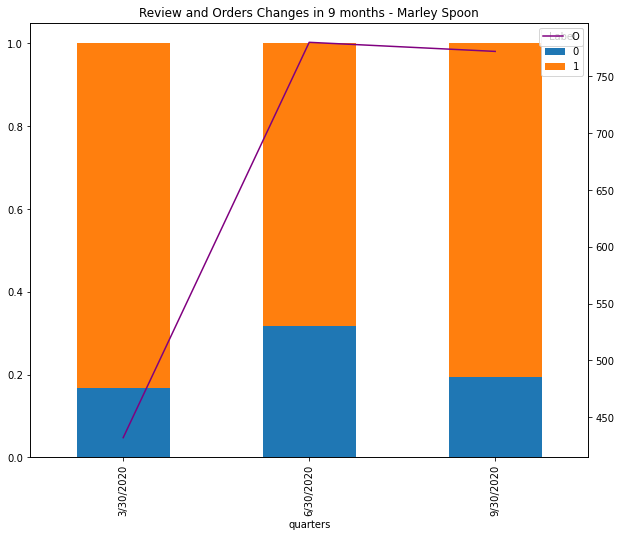

In [20]:
fig = plt.figure()
ax3 = marley_spoon_crossTab_quarterly.plot(kind = "bar", figsize = (10,8), stacked = True)
ax4 = ax3.twinx()
ax4.plot(marley['Date'], marley['orders'], color = 'purple', label = "Orders")
ax4.legend('Order')
ax3.set_title('Review and Orders Changes in 9 months - Marley Spoon')

Text(0.5, 1.0, 'Review and Customers Changes in 9 months - Hello Fresh')

<Figure size 432x288 with 0 Axes>

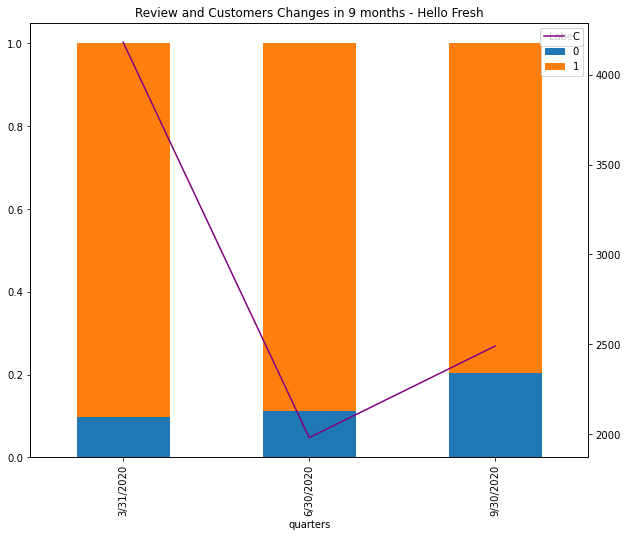

In [21]:
fig = plt.figure()
ax3 = hello_crossTab_quarterly.plot(kind = "bar", figsize = (10,8), stacked = True)
ax4 = ax3.twinx()
ax4.plot(hello_rev['Date'], hello_rev['customer'], color = 'purple', label = "Customers")
ax4.legend('Customers')
ax3.set_title('Review and Customers Changes in 9 months - Hello Fresh')

Text(0.5, 1.0, 'Review and Customers Changes in 9 months - Marley Spoon')

<Figure size 432x288 with 0 Axes>

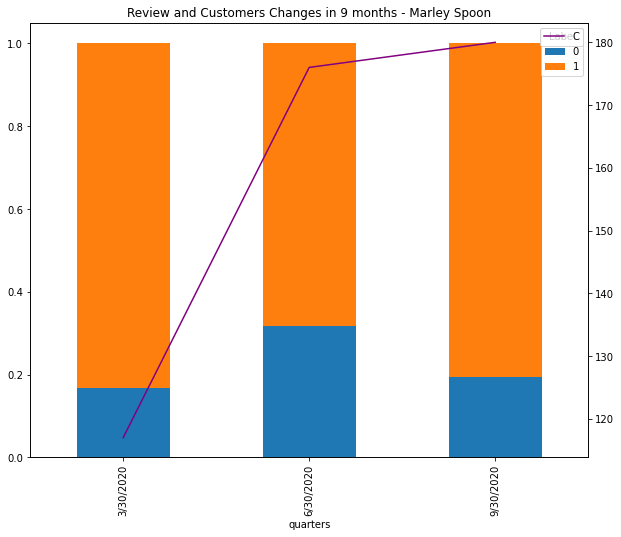

In [22]:
fig = plt.figure()
ax3 = marley_spoon_crossTab_quarterly.plot(kind = "bar", figsize = (10,8), stacked = True)
ax4 = ax3.twinx()
ax4.plot(marley['Date'], marley['customer'], color = 'purple', label = "Customers")
ax4.legend('Customers')
ax3.set_title('Review and Customers Changes in 9 months - Marley Spoon')